## 텍스트 전처리 및 시각화 연습문제

#### 주어진 뉴스기사 데이터를 파악하고, 필요한 컬럼에 대하여 전처리하여 분석하시오.
- 데이터 파일 : 'kor_news_240326.xlsx'

### 1. 필요한 모듈 임포트

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from konlpy.tag import Okt, Kkma
from nltk.corpus import stopwords
from matplotlib import font_manager, rc
import re

### 2. 데이터 읽고 파악하기

In [2]:
news = pd.read_excel('data/kor_news_240326.xlsx')
news.head(3)

,식별자,언론사,기고자,제목,분류,본문,URL
0,1,디지털타임스,박순원,"DL이앤씨, 올 매출목표 8.9조 성장 수익성 두 토끼 잡는다",경제>금융_재테크,"DL이앤씨, 안정적 재무구조 바탕으로 수익성 중심 내실경영\n\n\n\n'24년 매...",http://www.dt.co.kr/contents.html?article_no=2...
1,2,디지털타임스,박순원,"한신공영, 정선 임계~동해 신흥 도로건설공사 수주",지역>광주,한신공영이 1373억원 규모의 '국도42호선 정선 임계~동해 신흥 도로건설공사'를 ...,http://www.dt.co.kr/contents.html?article_no=2...
2,3,디지털타임스,박순원,기후카드 충전 편해져요 27일부터 신용카드 가능,경제>금융_재테크,서울시는 오는 27일부터 기후동행카드 실물카드를 신용카드나 체크카드로도 충전할 수 ...,http://www.dt.co.kr/contents.html?article_no=2...


In [3]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19425 entries, 0 to 19424
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   식별자     19425 non-null  int64 
 1   언론사     19425 non-null  object
 2   기고자     18452 non-null  object
 3   제목      19425 non-null  object
 4   분류      19425 non-null  object
 5   본문      19425 non-null  object
 6   URL     18091 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.0+ MB


In [4]:
news.isna().sum()

식별자       0
언론사       0
기고자     973
제목        0
분류        0
본문        0
URL    1334
dtype: int64

In [5]:
news[news['기고자'].isna() == 1].head(3)

,식별자,언론사,기고자,제목,분류,본문,URL
32,33,매일경제,NaN,AI 시대에도 살아남는 교육은? 인류 최고 지성들의 두뇌를 우리 아이 뇌에 다운로드...,사회>교육_시험,"4차 산업혁명을 뇌인지적 관점에서 바라보면 사물도 인간처럼 느끼고, 생각하고, 행동...",http://www.mk.co.kr/article/10971447
33,34,매일경제,NaN,"아랍에미리트의 향기, 오우드의 매혹적인 세계 [파일럿 Johan의 아라비안나이트]",문화>출판,[파일럿 Johan의 아라비안나이트-17]\n인간다운 따뜻한 마음을 지닌 사람에게서...,http://www.mk.co.kr/article/10973769
35,36,매일경제,NaN,"과천지식정보타운 지식산업센터, 3년 후 제2 판교 기대한다는데 [감평사의 부동산 현...",경제>부동산,서울 지하철 4호선 인덕원역 8번 출구로 나오면 넓은 도로와 함께 맞은편에 옹기종기...,http://www.mk.co.kr/article/10971639


### 3. 분야별로 뉴스 데이터 구분하기

- '분류' 컬럼을 정제하고 전처리하여 뉴스 분류 키워드들(예. 경제, 사회, 문화, 스포츠 등)을 추출하고,
- 분류한 키워드를 기준으로 각 뉴스를 구분하는 '구분' 컬럼을 생성

In [6]:
news['분류'].unique()

array(['경제>금융_재테크', '지역>광주', '사회>여성', '스포츠>올림픽_아시안게임', '경제>취업_창업', '미분류',
       '경제>부동산', '문화>방송_연예', '경제>경제일반', '사회>사건_사고', '스포츠>축구', '사회>의료_건강',
       '정치>국회_정당', 'IT_과학>인터넷_SNS', '지역>울산', '경제>유통', '문화>요리_여행', '지역>충남',
       '사회>교육_시험', '문화>전시_공연', '문화>문화일반', '문화>음악', '사회>노동_복지', '지역>대전',
       '사회>장애인', '문화>출판', '경제>반도체', '경제>자원', '정치>청와대', '정치>정치일반',
       'IT_과학>과학', '국제>미국_북미', '경제>자동차', 'IT_과학>콘텐츠', '경제>산업_기업',
       '국제>아시아', 'IT_과학>보안', '사회>미디어', '지역>강원', '문화>영화', '지역>충북', '문화>생활',
       '경제>서비스_쇼핑', '국제>중국', '사회>날씨', '지역>경남', 'IT_과학>모바일', '정치>선거',
       '국제>일본', 'IT_과학>IT_과학일반', '문화>미술_건축', '경제>외환', '국제>중동_아프리카',
       '지역>대구', '지역>부산', '정치>행정_자치', '경제>증권_증시', '지역>전남', '지역>경기',
       '사회>사회일반', '지역>전북', '국제>유럽_EU', '정치>북한', '경제>국제경제', '정치>외교',
       '경제>무역', '사회>환경', '스포츠>스포츠일반', '스포츠>야구>메이저리그', '국제>중남미',
       '문화>학술_문화재', '스포츠>농구_배구', '지역>제주', '스포츠>골프', '스포츠>야구', '국제>러시아',
       '지역>지역일반', '국제>국제일반', '스포츠>축구>해외축구', '스포츠>야구>한국프로야구', '스포츠>월드컵',
       '지역>경북', '스

In [12]:
news['구분'] = [i.split('>')[0] for i in news['분류']]
news.head(3)

,식별자,언론사,기고자,제목,분류,본문,URL,구분
0,1,디지털타임스,박순원,"DL이앤씨, 올 매출목표 8.9조 성장 수익성 두 토끼 잡는다",경제>금융_재테크,"DL이앤씨, 안정적 재무구조 바탕으로 수익성 중심 내실경영\n\n\n\n'24년 매...",http://www.dt.co.kr/contents.html?article_no=2...,경제
1,2,디지털타임스,박순원,"한신공영, 정선 임계~동해 신흥 도로건설공사 수주",지역>광주,한신공영이 1373억원 규모의 '국도42호선 정선 임계~동해 신흥 도로건설공사'를 ...,http://www.dt.co.kr/contents.html?article_no=2...,지역
2,3,디지털타임스,박순원,기후카드 충전 편해져요 27일부터 신용카드 가능,경제>금융_재테크,서울시는 오는 27일부터 기후동행카드 실물카드를 신용카드나 체크카드로도 충전할 수 ...,http://www.dt.co.kr/contents.html?article_no=2...,경제


### 4. '제목' 컬럼 데이터 전처리 및 시각화

- 제목 컬럼 데이터를 전처리하고(구두점, 조사 등 제거)
- 분야별 빈도가 높은 키워드를 추출하여
- 분야별 막대그래프와 워드클라우드로 시각화

경제:
      freq
투자    167
기업    159
산업    157
브랜드   155
한국    154
사업    153
지원    130
증권    128
금융    122
연속    118
주가    113
시장    112
대표    109
글로벌   109
롯데    104
삼성    103
강화    102
대출    101
출시    100
성장     98


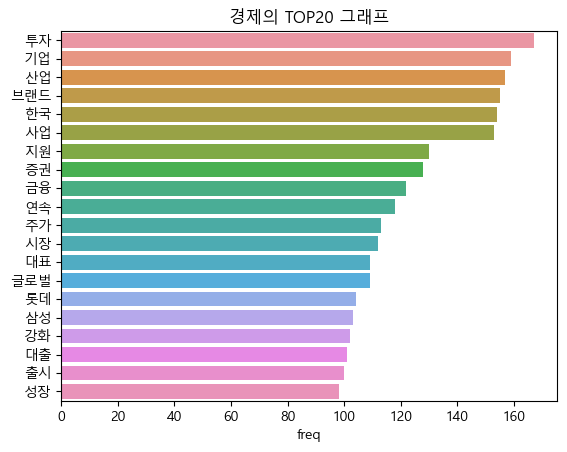

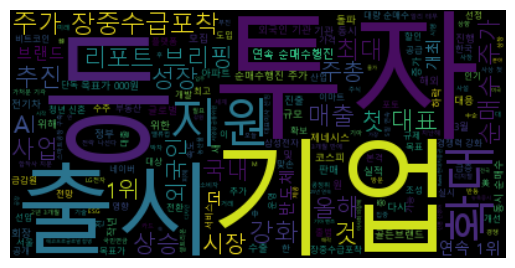

In [42]:
def news_dist(names,n=10):
    
    okt = Okt()
    stopwords_kr = pd.read_csv('data/한국어 불용어 리스트.csv', encoding='CP949')
    stopwords_list = stopwords_kr.values.tolist()
    
    # '구분'으로 그룹화
    group_news = news.groupby('구분')
    stop_words = stopwords_list
    
    for name, data in group_news:
        if name == names:
        # 그룹별 제목을 합치기
            title = ' '.join(data['제목'])
            # 단어 토큰화
            word_tokens = okt.pos(title)
            # 명사만 추출 / 1글자 이하 제거 / 불용어 제거
            token_sw = [word for word, tag in word_tokens if len(word)>1 if tag == 'Noun' if word not in stop_words]
            freq = pd.DataFrame(pd.Series(Counter(token_sw)).sort_values(ascending=False),columns=['freq'])
            print(f'{name}:\n {freq.head(n)}')
        
            # 바그래프 시각화
            data = freq.iloc[:n]
            sns.barplot(data,x='freq',y=data.index)
            plt.title(f'{name}의 TOP{n} 그래프')
            plt.show()
            
            # 워드 클라우드 시각화
            font_path = 'C:/Windows/Fonts/malgun.ttf'
            wordcloud=WordCloud(font_path=font_path).generate(title)
            plt.axis('off')
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.show()

news_dist('경제',20)

In [33]:
okt.pos(news['제목'][1], stem=True)

[('한', 'Determiner'),
 ('신', 'Modifier'),
 ('공영', 'Noun'),
 (',', 'Punctuation'),
 ('정선', 'Noun'),
 ('임계', 'Noun'),
 ('~', 'Punctuation'),
 ('동해', 'Noun'),
 ('신흥', 'Noun'),
 ('도로', 'Noun'),
 ('건설', 'Noun'),
 ('공사', 'Noun'),
 ('수주', 'Noun')]

In [45]:
result = []
for i in range(10):
    tags = okt.pos(news['제목'][i], stem=True)
    for word, tag in tags:
        if tag not in ['Determiner','Punctuation','Josa','Suffix','Modifier','Foreign']:
            result.append((word, tag))
print(result)

[('DL', 'Alpha'), ('앤', 'Noun'), ('오다', 'Verb'), ('매출', 'Noun'), ('목표', 'Noun'), ('8.9조', 'Number'), ('성장', 'Noun'), ('수익', 'Noun'), ('두', 'Noun'), ('토끼', 'Noun'), ('잡다', 'Verb'), ('공영', 'Noun'), ('정선', 'Noun'), ('임계', 'Noun'), ('동해', 'Noun'), ('신흥', 'Noun'), ('도로', 'Noun'), ('건설', 'Noun'), ('공사', 'Noun'), ('수주', 'Noun'), ('기후', 'Noun'), ('카드', 'Noun'), ('충전', 'Noun'), ('편하다', 'Adjective'), ('27일', 'Number'), ('신용카드', 'Noun'), ('가능', 'Noun'), ('낳다', 'Verb'), ('하다', 'Verb'), ('지자체', 'Noun'), ('키우다', 'Verb'), ('장기', 'Noun'), ('지원', 'Noun'), ('책', 'Noun'), ('꺼내다', 'Verb'), ('전남', 'Noun'), ('송범', 'Noun'), ('진', 'Noun'), ('크리에이터', 'Noun'), ('배드민턴', 'Noun'), ('대한민국', 'Noun'), ('최고', 'Noun'), ('인기', 'Noun'), ('스포츠', 'Noun'), ('되다', 'Verb'), ('S', 'Alpha'), ('크리에이터', 'Noun'), ('LH', 'Alpha'), ('희망', 'Noun'), ('상가', 'Noun'), ('307', 'Number'), ('호', 'Noun'), ('공급', 'Noun'), ('청년', 'Noun'), ('녀', 'Noun'), ('등', 'Noun'), ('대상', 'Noun'), ('송영', 'Noun'), ('숙', 'Noun'), ('한미', 'Noun'), ('회장', 'Noun'

### 5. '본문' 컬럼 데이터 전처리 및 시각화

- 본문 컬럼 데이터를 전처리하고
- 빈도가 높은 키워드를 추출하여(구분/분야별로)
- 막대그래프와 워드클라우드로 시각화

----